<h1 align=center> Linear Regression </h1> 

A demonstrative jupyter notebook on Linear Regression for predicting the house sale prices using a set of features obtained from the Kaggle House Prices dataset (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

### Setting up dataset & selecting features

In [2]:
train_data = pd.read_csv('data/train.csv') # load the training data
test_data = pd.read_csv('data/test.csv') # load the test data
print(train_data.columns)   # visualise the columns
train_data.head()   # visualise a subset of the training data

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# choose the columns to be used for training and testing, here we discard columns which do not have numerical values
columns = ['Id', 'LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice']

# remove extra columns from the train data
print(f'Train Data Size: {train_data.shape}')
train_data = train_data[columns]
print(train_data.head())

# remove extra columns from the test data
print(f'Test Data Size: {test_data.shape}')
test_data = test_data[columns[:-1]]
print(test_data.head())

Train Data Size: (1460, 81)
   Id  LotFrontage  LotArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0   1         65.0     8450         706           0        150          856   
1   2         80.0     9600         978           0        284         1262   
2   3         68.0    11250         486           0        434          920   
3   4         60.0     9550         216           0        540          756   
4   5         84.0    14260         655           0        490         1145   

   MasVnrArea  1stFlrSF  2ndFlrSF  ...  GarageArea  WoodDeckSF  OpenPorchSF  \
0       196.0       856       854  ...         548           0           61   
1         0.0      1262         0  ...         460         298            0   
2       162.0       920       866  ...         608           0           42   
3         0.0       961       756  ...         642           0           35   
4       350.0      1145      1053  ...         836         192           84   

   EnclosedPorch  3Ssn

### Pre-processing data

In [4]:
# function for pre-processing the data
def pre_process(data, train=True, val_split=0.8, seed=1234):
    # remove the NaN values from data
    for i in range(data.shape[1]):
        data = data.iloc[data.iloc[:, i].notna().to_numpy()]
    if train:
        data = data.iloc[:, 1:] # exclude the "Id" column
        np.random.seed(seed)
        split = val_split
        indices = np.arange(data.shape[0])  
        np.random.shuffle(indices)  # shuffle indices for validation split
        mu = data.iloc[:, :-1].mean(0)  # calculate mean
        sigma = data.iloc[:, :-1].std(0)    # calculate std
        # split the train and validation sets
        X_train, y_train, X_val, y_val = data.iloc[indices[:int(split*len(indices))], :-1], data.iloc[indices[:int(split*len(indices))], -1], data.iloc[indices[int(split*len(indices)):], :-1], data.iloc[indices[int(split*len(indices)):], -1]   

        X_train -= mu
        X_train /= sigma    # normalize the train set
        X_val -= mu
        X_val /= sigma  # normalize the validation set
        X_train = np.c_[np.ones(len(X_train),dtype='int64'), X_train.to_numpy()]    # append 1s to the features in train set
        X_val = np.c_[np.ones(len(X_val),dtype='int64'), X_val.to_numpy()]  # append 1s to the features in validation set
        
        print(f'\nTraining Size: {X_train.shape[0]}')
        print(f'Validation Size: {X_val.shape[0]}')
        print(f'Number of features: {X_train.shape[1]}')

        return X_train, y_train.to_numpy(), X_val, y_val.to_numpy()

    else:
        data = data.iloc[:, 1:] # exclude the "Id" column
        mu = data.mean(0)   # calculate mean
        sigma = data.std(0) # calculate std
        X_test = data
        X_test -= mu
        X_test /= sigma # normalize the test set
        X_test = np.c_[np.ones(len(X_test),dtype='int64'), X_test.to_numpy()]    # append 1s to the features in test set
        
        print(f'Testing Size: {X_test.shape[0]}')
        return X_test

### Model

In [5]:
class LinReg:
    '''
    Linear Regression Model
    '''
    def __init__(self):
        # place_holders
        self.coeffs = None
        self.alpha = 0.1
        self.iterations = 100
        self.train_loss = []

    def train(self, X, y):
        # train using batch gradient descent
        self.train_loss.append(self.criterion(X, y))    # append initial loss
        for t in tqdm(range(self.iterations)):
            gradient = np.dot(X.T, (np.dot(X, self.coeffs) - y)) / len(y)   # compute gradient of cost function
            self.coeffs -= self.alpha * gradient    # update weights
            loss = self.criterion(X, y) # compute loss
            self.train_loss.append(loss)    # append loss
    
    def fit(self, X, y, alpha=0.1, ITERATIONS=100, coeffs=None):
        # main function of linear regression
        if coeffs == None:
            self.coeffs = np.zeros(X.shape[1])  # initalise coefficients to zeros
        else:
            self.coeffs = coeffs
        self.alpha = alpha  # learning rate
        self.iterations = ITERATIONS    # number of iterations
        self.train(X, y)    # train

    def predict(self, X, do_print=True):
        # predict the sale price using computed weights
        if do_print:
            print(np.dot(X, self.coeffs))
        else:
            return np.dot(X, self.coeffs)

    def criterion(self, X, y):
        # cost function
        return np.sum((X.dot(self.coeffs) - y) ** 2) / (2 * len(y))
    
    def score(self, X, target):
        # computing r^2 (coefficient)
        predictions = self.predict(X, do_print=False)   # get predictions
        tss = np.sum((target - target.mean()) ** 2) # total sum of squares
        rss = np.sum((predictions - target) ** 2)   # residual sum of squares
        r2 = 1 - (rss/tss)  # r^2 coefficient
        print(f'\n{r2}')
    
    def mse(self, X, target):
        # computing normalised mean squared error
        predictions = self.predict(X, do_print=False)   # get predictions
        mse = (predictions - target) ** 2   # sqaured errors
        mse = np.sum(mse) / (len(target) * np.max(mse)) # sum squared errors / len(y) * max(error)
        print(mse)
    
    def get_params(self):
        # get weights and loss
        return self.coeffs, self.train_loss

### Splitting datasets

In [6]:
X_train, y_train, X_val, y_val = pre_process(train_data)    # pre-process the training data
X_test = pre_process(test_data, train=False)    # pre-process the test data


Training Size: 956
Validation Size: 239
Number of features: 28
Testing Size: 1218


### Training and validation

In [7]:
lr = LinReg()   # instantiate the model
lr.fit(X_train, y_train)    # fit the model on train data
coeffs, losses = lr.get_params()    # get the weights and losses
lr.score(X_val, y_val)  # compute r^2 over validation set
lr.mse(X_val, y_val)  # compute mse over validation set
# print(losses)

100%|██████████| 100/100 [00:00<00:00, 1321.57it/s]
0.7096879063120913
0.015730479422307864



### Plotting loss & weights

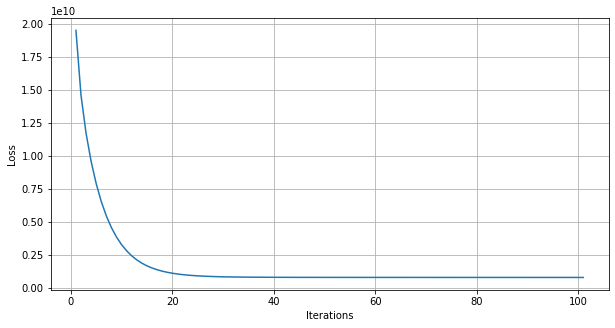

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(losses) + 1, 1), losses)  # plot the variation of loss with iterations
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

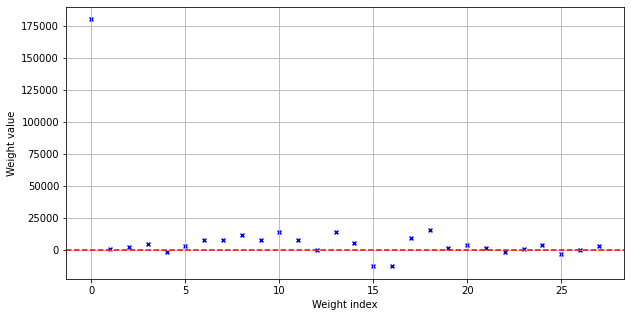

In [9]:
# plotting the weights
plt.figure(figsize=(10,5))
plt.scatter(range(len(coeffs)),coeffs,15,'b','x')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.ylabel('Weight value')
plt.xlabel('Weight index')
plt.show()

### Predictions

In [10]:
lr.predict(X_test)  # predictions for test data

[118551.09704607 163838.75199643 198342.33227318 ... 179646.93760606
  83822.20698335 268989.20676834]


### sklearn Linear Model

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
reg = LinearRegression().fit(X_train, y_train)  # instantiate the sklearn linear regression model
reg.score(X_val, y_val) # get the score on validation set using sklearn model weights

0.708151631703497

In [13]:
# normalised mse using sklearn model weights
predictions = reg.predict(X_val)
mse = (predictions - y_val) ** 2
mse = np.sum(mse) / (len(y_val) * np.max(mse))
print(mse)

0.015494251551341775


In [14]:
reg.predict(X_test) # make predictions on test set using sklearn model weights

array([111369.74141593, 163374.33191975, 199236.10688585, ...,
       180042.94189319,  85110.4699075 , 271525.11022229])

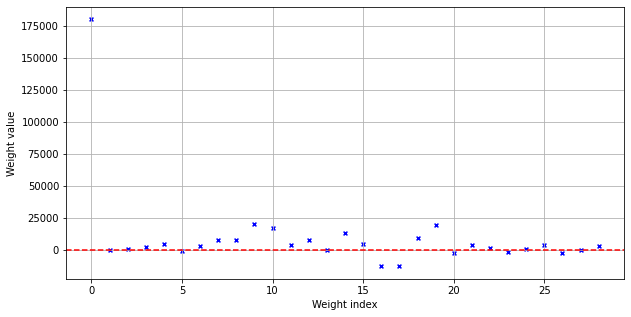

In [15]:
# plotting the sklearn model weights
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(reg.coef_) + 1), np.c_[np.array([reg.intercept_]).reshape(-1, 1).T, reg.coef_.reshape(-1, 1).T].reshape(-1), 15, 'b', 'x')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.ylabel('Weight value')
plt.xlabel('Weight index')
plt.show()